In [1]:
import itertools
import operator
import re
from abc import *
from operator import itemgetter
from typing import *
import numpy as np
import scipy as sp
import networkx as nx
import mne
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors._dist_metrics import DistanceMetric
from sklearn.utils import shuffle
from typing import List, Tuple
from sklearn.model_selection import train_test_split
from nodestimation.learning.estimation import collect_statistic, \
    compute_importance, collect_cross_statistic, make_selection_map, \
    select, separate_datasets, selected_statistic, choose_best, selected_data, make_feature_selection
from nodestimation.processing.features import prepare_features
from nodestimation.project import find_subject_dir, conditions_unique_code
from nodestimation.pipeline import pipeline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import nilearn.plotting as nplt
from nodestimation.project.actions import read
import nodestimation as nd
from nodestimation.learning.modification import append_series, promote
import nodestimation.learning.modification as lmd
from nodestimation.project.subject import Subject
from sklearn.preprocessing import *
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib as mpl
from nodestimation.learning.selection import SubjectsStatistic, Wilcoxon, Mannwhitneyu, Test
from scipy.stats import wilcoxon
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from scipy.fftpack import fftfreq, irfft, rfft
from scipy.fftpack import fftfreq, irfft, rfft


def dict_to_str(dictionary: dict, space: int = 0):
    tab = lambda space: '  '*space
    string = f'{{\n'
    space += 1
    for key, value in zip(dictionary.keys(), dictionary.values()):
        if not isinstance(key, str):
            key = f'{key}'
        if '\n' in key:
            key = key.replace('\n', '')
        string += f'{tab(space)}{key}: '
        if not isinstance(value, dict):
            string += f'{value},\n'
        else:
            string += dict_to_str(value, space+1)
    string += f'{tab(space - 1)}}}\n'
    return string


def sparse_graph(g: nx.Graph) -> nx.Graph:
    con = nx.to_numpy_matrix(g)
    out = nx.from_numpy_matrix(
        lmd.suppress(
            pd.DataFrame(
                con
            ),
            trigger=con.mean().mean(),
            optimal=0
        ).to_numpy()
    )
    mapping = {node: label_name for node, label_name in zip(out, g)}
    out = nx.relabel_nodes(out, mapping)
    return out


def graph_to_connectome(g: nx.Graph) -> pd.DataFrame:
    return pd.DataFrame(
        nx.to_numpy_matrix(g),
        index= g.nodes,
        columns = g.nodes
    )


def labels_for_hemispheres(g: nx.Graph) -> Tuple[List[str], List[str]]:
    labels_rh, labels_lh = list(), list()
    for node in g.nodes:
        if 'lh' in node:
            labels_lh.append(node)
        elif 'rh' in node:
            labels_rh.append(node)
        else:
            raise ValueError(f'Wrong node name: {node}')
    return labels_lh, labels_rh


def hemispheres_division_modularity(g: nx.Graph) -> float:
    labels_lh, labels_rh = labels_for_hemispheres(g)
    return nx.algorithms.community.quality.modularity(g, [labels_lh, labels_rh])


def hemispheres_division_performance(g: nx.Graph) -> float:
    labels_lh, labels_rh = labels_for_hemispheres(g)
    return nx.algorithms.community.quality.performance(g, [labels_lh, labels_rh])


def graph_to_hemispheres(g: nx.Graph) -> Tuple[nx.Graph, nx.Graph]:
    labels_lh, labels_rh = labels_for_hemispheres(g)
    return g.subgraph(labels_lh), g.subgraph(labels_rh)


def smallworldness(g: nx.Graph) -> Tuple[float, float]:
    return nx.algorithms.smallworld.sigma(g), nx.algorithms.smallworld.omega(g)


def s_for_hemispheres(subjects: List[Subject]) -> pd.DataFrame:
    dataset = pd.DataFrame()

    for subject in subjects:
        resected_hemisphere = None
        lupd, rupd = dict(), dict()

        for node in subject.nodes:
            if node.type == 'resected' and 'rh' in node.label.name:
                lupd.update({'resected': False})
                rupd.update({'resected': True})
                break

            elif node.type == 'resected' and 'lh' in node.label.name:
                lupd.update({'resected': True})
                rupd.update({'resected': False})
                break

        for freq in subject.graph:
            for method in subject.graph[freq]:
                G = sparse_graph(subject.graph[freq][method])
                lh, rh = graph_to_hemispheres(G)
                lupd.update({f's_for_{method}': nx.algorithms.smetric.s_metric(lh, normalized=False)/100000})
                rupd.update({f's_for_{method}': nx.algorithms.smetric.s_metric(rh, normalized=False)/100000})

        dataset = append_series(dataset, pd.Series(lupd), index=f'{subject.name}_lh')
        dataset = append_series(dataset, pd.Series(rupd), index=f'{subject.name}_rh')

    return dataset


def metric_for_hemispheres(subjects: List[Subject], metric: Callable, **kwargs) -> pd.DataFrame:
    dataset = pd.DataFrame()

    for subject in subjects:
        start = time.time()
        resected_hemisphere = None
        lupd, rupd = dict(), dict()

        for node in subject.nodes:
            if node.type == 'resected' and 'rh' in node.label.name:
                lupd.update({'resected': False})
                rupd.update({'resected': True})
                break

            elif node.type == 'resected' and 'lh' in node.label.name:
                lupd.update({'resected': True})
                rupd.update({'resected': False})
                break

        for freq in subject.graph:
            for method in subject.graph[freq]:
                G = sparse_graph(subject.graph[freq][method])
                lh, rh = graph_to_hemispheres(G)
                lupd.update({f'{metric.__name__}_for_{method}': metric(lh, **kwargs)})
                rupd.update({f'{metric.__name__}_for_{method}': metric(rh, **kwargs)})

        dataset = append_series(dataset, pd.Series(lupd), index=f'{subject.name}_lh')
        dataset = append_series(dataset, pd.Series(rupd), index=f'{subject.name}_rh')
        print(f'{subject.name}: DONE, RUNTIME: {time.time() - start}')

    return dataset

class Informativeness(ABC):

    @property
    def informativeness(self):
        return self

    def sorted(self, *args, **kwargs):
        pass

class NodesInformativeness(Informativeness):
    def __init__(self):
        self._subjective, self._anatomical = tuple(
            {
                'correct': {'true': dict(), 'false': dict()},
                'wrong': {'true': dict(), 'false': dict()}
            }
            for _ in range(2)
        )

    @property
    def subjective(self):
        return self._subjective

    @property
    def anatomical(self):
        return self._anatomical

    @property
    def informativeness(self):
        return self._subjective, self._anatomical

    @informativeness.setter
    def informativeness(self, sample: Tuple[str, bool, str]):
        sample_name, positive, group = sample
        if positive:
            subjective_container = self._subjective[group]['true']
            anatomical_container = self._anatomical[group]['true']
        else:
            subjective_container = self._subjective[group]['false']
            anatomical_container = self._anatomical[group]['false']
        if sample_name in subjective_container:
            subjective_container[sample_name] += 1
            anatomical_container[sample_name[5:]] += 1
        else:
            subjective_container.update({sample_name: 1})
            anatomical_container.update({sample_name[5:]: 1})

    @anatomical.setter
    def anatomical(self, value: Any):
        raise PermissionError('Impossible to set value to anatomical')

    @subjective.setter
    def subjective(self, value: Any):
        raise PermissionError('Impossible to set value to subjective')

    def sorted(self, container_name: str, prediction: str, positive: bool, type: str = 'growth', reverse: bool = False):

        def rating_sort(container_name: str, prediction: str, key: str) -> Callable:

            contrary = 'correct' if prediction == 'wrong' else 'wrong'

            def sort_tool(item: Tuple[str, int]) -> Union[int, float]:
                mistakes = self.__dict__['_' + container_name][contrary][key][item[0]] + 1 if item[0] in self.__dict__['_' + container_name][contrary][key] else 1
                return item[1]/mistakes

            return sort_tool

        if type == 'growth':
            return dict(
                sorted(
                    self.__dict__
                    ['_' + container_name]
                    [prediction]
                    [str(positive).lower()]
                        .items(),
                    key=lambda item: item[1],
                    reverse=reverse)
            )
        elif type == 'rating':
            return dict(
                sorted(
                    self.__dict__
                    ['_' + container_name]
                    [prediction]
                    [str(positive).lower()]
                        .items(),
                    key=rating_sort(container_name, prediction, str(positive).lower()),
                    reverse=reverse)
            )


class SubjectsInformativeness(Informativeness):
    def __init__(self):
        self._informativeness = {
                'correct': {'true': dict(), 'false': dict()},
                'wrong': {'true': dict(), 'false': dict()}
            }

    @property
    def informativeness(self):
        return self._informativeness

    @informativeness.setter
    def informativeness(self, sample: Tuple[str, bool, str]):
        sample_name, positive, group = sample
        subject_name = sample_name[:4]
        if positive:
            container = self._informativeness[group]['true']
        else:
            container = self._informativeness[group]['false']
        if subject_name in container:
            container[subject_name] += 1
        else:
            container.update({subject_name: 1})

    def sorted(self, prediction: str, positive: bool, type: str = 'growth', reverse: bool = False):

        def rating_sort(prediction: str, key: str) -> Callable:

            contrary = 'correct' if prediction == 'wrong' else 'wrong'

            def sort_tool(item: Tuple[str, int]) -> Union[int, float]:
                mistakes = self._informativeness[contrary][key][item[0]] + 1 if item[0] in self._informativeness[contrary][key] else 1
                return item[1]/mistakes

            return sort_tool

        if type == 'growth':
            return dict(
                sorted(
                    self._informativeness
                    [prediction][str(positive).lower()].items(),
                    key=lambda item: item[1],
                    reverse=reverse)
            )
        elif type == 'rating':
            return dict(
                sorted(
                    self._informativeness
                    [prediction][str(positive).lower()].items(),
                    key=rating_sort(prediction, str(positive).lower()),
                    reverse=reverse)
            )


class NodesCrossInformativeness(Informativeness):
    def __init__(self):
        self._subjective, self._anatomical = tuple(
            {
                'correct': {'true': dict(), 'false': dict()},
                'wrong': {'true': dict(), 'false': dict()}
            }
            for _ in range(2)
        )

    @property
    def subjective(self):
        return self._subjective

    @property
    def anatomical(self):
        return self._anatomical

    @property
    def informativeness(self):
        return self._subjective, self._anatomical

    @informativeness.setter
    def informativeness(self, info: NodesInformativeness):
        for inner_stat, outer_stat in zip((self.anatomical, self.subjective), info.informativeness):
            for correctness in outer_stat:
                if correctness in inner_stat:
                    for positiveness in outer_stat[correctness]:
                        if positiveness in inner_stat[correctness]:
                            for name in outer_stat[correctness][positiveness]:
                                if name in inner_stat[correctness][positiveness]:
                                    inner_stat[correctness][positiveness][name] = np.append(
                                        inner_stat[correctness][positiveness][name],
                                        outer_stat[correctness][positiveness][name]
                                    )
                                else:
                                    inner_stat[correctness][positiveness].update({
                                        name: np.array([
                                            outer_stat[correctness][positiveness][name]
                                        ])
                                    })
                        else:
                            inner_stat[correctness].update({
                                positiveness: self.numeric_keys_to_numpy(
                                    outer_stat[correctness][positiveness]
                                )
                            })

    def numeric_keys_to_numpy(self, dictionary: dict):
        for key in dictionary:
            if isinstance(dictionary[key], dict):
                self.numeric_keys_to_numpy(dictionary[key])
            elif isinstance(dictionary[key], int) or isinstance(dictionary[key], float):
                dictionary[key] = np.array([dictionary[key]])
            elif isinstance(dictionary[key], list):
                dictionary[key] = np.array(dictionary[key])
            elif isinstance(dictionary[key], np.ndarray):
                continue

        return dictionary

    def mean(self):
        def numpy_to_mean(dictionary: Dict[str, np.ndarray]):
            return {
                key: dictionary[key].mean()
                for key in dictionary
            }

        def dict_to_mean(dictionary: dict):
            return {
                correctness: {
                    positiveness: numpy_to_mean(dictionary[correctness][positiveness])
                    for positiveness in dictionary[correctness]
                }
                for correctness in dictionary
            }

        subjective, anatomical = self.informativeness

        return dict_to_mean(subjective), dict_to_mean(anatomical)

    def std(self):
        def numpy_to_std(dictionary: Dict[str, np.ndarray]):
            return {
                key: dictionary[key].std()
                for key in dictionary
            }

        def dict_to_mean(dictionary: dict):
            return {
                correctness: {
                    positiveness: numpy_to_std(dictionary[correctness][positiveness])
                    for positiveness in dictionary[correctness]
                }
                for correctness in dictionary
            }

        subjective, anatomical = self.informativeness

        return dict_to_mean(subjective), dict_to_mean(anatomical)

    @anatomical.setter
    def anatomical(self, value: Any):
        raise PermissionError('Impossible to set value to anatomical')

    @subjective.setter
    def subjective(self, value: Any):
        raise PermissionError('Impossible to set value to subjective')

    def sorted(self, container_name: str, prediction: str, type: str = 'growth', reverse: bool = False):

        def rating_sort(container_name: str, prediction: str) -> Callable:

            contrary = 'correct' if prediction == 'wrong' else 'wrong'

            def sort_tool(item: Tuple[str, int]) -> Union[int, float]:
                key, value = item
                contr_mean = self.__dict__['_' + container_name][contrary]['true'][key].mean() \
                    if key in self.__dict__['_' + container_name][contrary]['true'] else 1 *\
                    self.__dict__['_' + container_name][contrary]['false'][key].mean() \
                    if key in self.__dict__['_' + container_name][contrary]['false'] else 1
                contr_std = self.__dict__['_' + container_name][contrary]['true'][key].std() \
                    if key in self.__dict__['_' + container_name][contrary]['true'] else 1 *\
                    self.__dict__['_' + container_name][contrary]['false'][key].std() \
                    if key in self.__dict__['_' + container_name][contrary]['false'] else 1
                return value.mean()/\
                       value.std()/\
                       contr_mean/\
                       contr_std


            return sort_tool

        if type == 'growth':
            return dict(
                sorted(
                    list(
                        self.__dict__
                        ['_' + container_name]
                        [prediction]
                        ['true']
                            .items()
                    ) +
                    list(
                        self.__dict__
                        ['_' + container_name]
                        [prediction]
                        ['false']
                            .items()
                    ),
                    key=lambda item: item[1].mean(),
                    reverse=reverse)
            )
        elif type == 'rating':
            return dict(
                sorted(
                    list(
                        self.__dict__
                        ['_' + container_name]
                        [prediction]
                        ['true']
                            .items()
                    ) +
                    list(
                        self.__dict__
                        ['_' + container_name]
                        [prediction]
                        ['false']
                            .items()
                    ),
                    key=rating_sort(container_name, prediction),
                    reverse=reverse)
            )


class SubjectsCrossInformativeness(Informativeness):
    def __init__(self):
        self._informativeness = {
                'correct': {'true': dict(), 'false': dict()},
                'wrong': {'true': dict(), 'false': dict()}
            }

    @property
    def informativeness(self):
        return self._informativeness

    @informativeness.setter
    def informativeness(self, info: SubjectsInformativeness):
        inner_stat, outer_stat = self.informativeness, info.informativeness
        for correctness in outer_stat:
            if correctness in inner_stat:
                for positiveness in outer_stat[correctness]:
                    if positiveness in inner_stat[correctness]:
                        for name in outer_stat[correctness][positiveness]:
                            if name in inner_stat[correctness][positiveness]:
                                inner_stat[correctness][positiveness][name] = np.append(
                                    inner_stat[correctness][positiveness][name],
                                    outer_stat[correctness][positiveness][name]
                                )
                            else:
                                inner_stat[correctness][positiveness].update({
                                    name: np.array([
                                        outer_stat[correctness][positiveness][name]
                                    ])
                                })
                    else:
                        inner_stat[correctness].update({
                            positiveness: self.numeric_keys_to_numpy(
                                outer_stat[correctness][positiveness]
                            )
                        })

    def numeric_keys_to_numpy(self, dictionary: dict):
        for key in dictionary:
            if isinstance(dictionary[key], dict):
                self.numeric_keys_to_numpy(dictionary[key])
            elif isinstance(dictionary[key], int) or isinstance(dictionary[key], float):
                dictionary[key] = np.array([dictionary[key]])
            elif isinstance(dictionary[key], list):
                dictionary[key] = np.array(dictionary[key])
            elif isinstance(dictionary[key], np.ndarray):
                continue

        return dictionary

    def mean(self):
        def numpy_to_mean(dictionary: Dict[str, np.ndarray]):
            return {
                key: dictionary[key].mean()
                for key in dictionary
            }

        def dict_to_mean(dictionary: dict):
            return {
                correctness: {
                    positiveness: numpy_to_mean(dictionary[correctness][positiveness])
                    for positiveness in dictionary[correctness]
                }
                for correctness in dictionary
            }

        info = self.informativeness
        return dict_to_mean(info)

    def std(self):
        def numpy_to_std(dictionary: Dict[str, np.ndarray]):
            return {
                key: dictionary[key].std()
                for key in dictionary
            }

        def dict_to_mean(dictionary: dict):
            return {
                correctness: {
                    positiveness: numpy_to_std(dictionary[correctness][positiveness])
                    for positiveness in dictionary[correctness]
                }
                for correctness in dictionary
            }

        info = self.informativeness

        return dict_to_mean(info)

    def sorted(self, prediction: str, correctness: str, type: str = 'growth', reverse: bool = False):

        def rating_sort(prediction: str) -> Callable:

            contrary = 'correct' if prediction == 'wrong' else 'wrong'

            def sort_tool(item: Tuple[str, int]) -> Union[int, float]:
                key, value = item
                contr_mean = self._informativeness[contrary][correctness][key].mean() \
                    if key in self._informativeness[contrary][correctness] else 1
                contr_std = self._informativeness[contrary][correctness][key].std() \
                    if key in self._informativeness[contrary][correctness] else 1
                return value.mean()/\
                       value.std()/\
                       contr_mean/\
                       contr_std


            return sort_tool

        if type == 'growth':
            return dict(
                sorted(
                    self._informativeness
                    [prediction]
                    [correctness]
                        .items()
                    ,
                    key=lambda item: item[1].mean(),
                    reverse=reverse)
            )
        elif type == 'rating':
            return dict(
                sorted(
                    self._informativeness
                    [prediction]
                    [correctness]
                        .items()
                    ,
                    key=rating_sort(prediction),
                    reverse=reverse)
            )

/home/user/PycharmProjects/NodesEstimation/venv/lib/python3.9/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# subjects = pipeline(
#     methods=['wpli', 'envelope'],
#     freq_bands=(7.5, 12),
#     centrality_metrics=['eigen', 'close', 'between', 'degree', ],# 'katz', 'info', 'harmonic']
#     subjects_specificity={
#         'M2S2': {
#             'freq_bands': (7.5, 12.5)
#         },
#         'R1D2': {
#             'freq_bands': (7.5, 11)
#         },
#         'S1A2': {
#             'freq_bands': (5, 10)
#         },
#         'S1H1': {
#             'freq_bands': (8, 13)
#         },
#         'K1V1': {
#             'freq_bands': (7.5, 11)
#         },
#         'L1P1': {
#             'freq_bands': (5, 10)
#         },
#         'M1G2': {
#             'freq_bands': (7, 11)
#         },
#         'G1V2': {
#             'freq_bands': (7, 11)
#         },
#         'G1R1': {
#             'freq_bands': (12.5, 16.5)
#         },
#         'M1N2': {
#             'freq_bands': (10, 15)
#         },
#         'B1R1': {
#             'freq_bands': (6, 11)
#         },
#         'B1C2': {
#             'freq_bands': (7.5, 12.5)
#         },
#         'J1T2': {
#             'freq_bands': (11, 15)
#         },
#         'O1O2': {
#             'freq_bands': (5.5, 9.5)
#         },
#     }
# )

# subjects = pipeline(
#     methods=['wpli', 'envelope'],
#     freq_bands=(4, 8),
#     centrality_metrics=['eigen', 'close', 'between', 'degree']
#     )

subjects = pipeline(
    methods=['wpli', 'envelope', 'coh', 'imcoh', 'plv', 'ciplv', 'ppc', 'pli', 'pli2_unbiased', 'wpli2_debiased'],
    freq_bands=(4, 8),
    centrality_metrics=['eigen', 'between', 'degree', 'info']
    )

# for subject in subjects:
#     for dataset in subject.datasets:
#         print(subject.datasets[dataset].head())
        # print(dataset)
        # print(subject.dataset[dataset])
        # columns = subject.dataset[dataset].columns.to_list()
        # rule = dict()
        # for column in columns:
        #     if 'wpli' in column:
        #         rule.update({column: 'wpli'})
        #     if 'envelope' in column:
        #         rule.update({column: 'envelope'})
        # subject.dataset[dataset] = subject.dataset[dataset].rename(columns=rule, copy=True)



datasets = {
    subject: {
        freq: {
            method: lmd.suppress(
                    subject.connectomes[freq][method],
                    trigger=subject.connectomes[freq][method].mean().mean(),
                    optimal=0
                )
            # method: subject.connectomes[freq][method]
           for method in subject.connectomes[freq]
        }
        for freq in subject.connectomes
    }
    for subject in subjects
}

All computation has been already done, loading of the existing file with the solution...


In [3]:
close, between, eigen, degree, info, harmony = dict(), dict(), dict(), dict(), dict(), dict()
for subject in datasets:
    close.update({subject.name: dict()})
    between.update({subject.name: dict()})
    eigen.update({subject.name: dict()})
    degree.update({subject.name: dict()})
    info.update({subject.name: dict()})
    harmony.update({subject.name: dict()})
    # katz.update({subject.name: dict()})
    for freq in datasets[subject]:
        for method in datasets[subject][freq]:
            print(subject.name, freq, method)
            label_names = datasets[subject][freq][method].columns
            if nx.is_connected(
                    nx.convert_matrix.from_numpy_array(
                        datasets[subject][freq][method].to_numpy()
                    )
            ):
                arr  = datasets[subject][freq][method].to_numpy()
            elif nx.is_connected(
                    nx.convert_matrix.from_numpy_array(
                        subject.connectomes[freq][method].to_numpy()
                    )
            ):
                arr = subject.connectomes[freq][method].to_numpy()
            else:
                raise ValueError(f'Graph not connected: {subject.name}, {freq}, {method}')
            if arr.min().min() < 0:
                for i in range(arr.shape[0]):
                    for j in range(arr.shape[1]):
                        if arr[i, j] != 0: arr[i, j] -= arr.min().min()
            G = nx.convert_matrix.from_numpy_array(arr)
            mapping = {node: label_name for node, label_name in zip(G, label_names)}
            G = nx.relabel_nodes(G, mapping)
            for place, data in zip(
                [
                    close[subject.name],
                    between[subject.name],
                    eigen[subject.name],
                    info[subject.name],
                    harmony[subject.name],
                    degree[subject.name],
                    # katz[subject.name]
                ],[
                        nx.closeness_centrality(G, distance='weight'),
                        nx.betweenness_centrality(G, weight='weight'),
                        nx.eigenvector_centrality_numpy(G, weight='weight'),
                        nx.information_centrality(G, weight='weight'),
                        nx.harmonic_centrality(G, distance='weight'),
                        dict(G.degree(weight='weight')),
                        # nx.katz_centrality(G, weight='weight', max_iter=100)
                    ]
            ):
                place.update({
                    freq + '_' + method: pd.Series(data)
                })

print('All is done')

M2S2 4-8Hz wpli
M2S2 4-8Hz envelope
M2S2 4-8Hz coh
M2S2 4-8Hz imcoh
M2S2 4-8Hz plv
M2S2 4-8Hz ciplv
M2S2 4-8Hz ppc
M2S2 4-8Hz pli
M2S2 4-8Hz pli2_unbiased
M2S2 4-8Hz wpli2_debiased
R1D2 4-8Hz wpli
R1D2 4-8Hz envelope
R1D2 4-8Hz coh
R1D2 4-8Hz imcoh
R1D2 4-8Hz plv
R1D2 4-8Hz ciplv
R1D2 4-8Hz ppc
R1D2 4-8Hz pli
R1D2 4-8Hz pli2_unbiased
R1D2 4-8Hz wpli2_debiased
S1A2 4-8Hz wpli
S1A2 4-8Hz envelope
S1A2 4-8Hz coh
S1A2 4-8Hz imcoh
S1A2 4-8Hz plv
S1A2 4-8Hz ciplv
S1A2 4-8Hz ppc
S1A2 4-8Hz pli
S1A2 4-8Hz pli2_unbiased
S1A2 4-8Hz wpli2_debiased
S1H1 4-8Hz wpli
S1H1 4-8Hz envelope
S1H1 4-8Hz coh
S1H1 4-8Hz imcoh
S1H1 4-8Hz plv
S1H1 4-8Hz ciplv
S1H1 4-8Hz ppc
S1H1 4-8Hz pli
S1H1 4-8Hz pli2_unbiased
S1H1 4-8Hz wpli2_debiased
K1V1 4-8Hz wpli
K1V1 4-8Hz envelope
K1V1 4-8Hz coh
K1V1 4-8Hz imcoh
K1V1 4-8Hz plv
K1V1 4-8Hz ciplv
K1V1 4-8Hz ppc
K1V1 4-8Hz pli
K1V1 4-8Hz pli2_unbiased
K1V1 4-8Hz wpli2_debiased
L1P1 4-8Hz wpli
L1P1 4-8Hz envelope
L1P1 4-8Hz coh
L1P1 4-8Hz imcoh
L1P1 4-8Hz plv
L1P1 4-8Hz c

In [4]:
datasets_centrality = dict()

for subject in subjects:
    datasets_centrality.update({subject.name: dict()})
    datasets_centrality[subject.name].update({
        'close': pd.DataFrame(close[subject.name]),
        'between': pd.DataFrame(between[subject.name]),
        'eigen': pd.DataFrame(eigen[subject.name]),
        'degree': pd.DataFrame(degree[subject.name]),
        'info': pd.DataFrame(info[subject.name]),
        'harmony': pd.DataFrame(harmony[subject.name]),
        # 'katz': pd.DataFrame(katz[subject.name])
    })
    true = subject.datasets['eigen']['resected']
    datasets_centrality[subject.name]['close'] = datasets_centrality[subject.name]['close'].assign(resected=true)
    datasets_centrality[subject.name]['between'] = datasets_centrality[subject.name]['between'].assign(resected=true)
    datasets_centrality[subject.name]['eigen'] = datasets_centrality[subject.name]['eigen'].assign(resected=true)
    datasets_centrality[subject.name]['degree'] = datasets_centrality[subject.name]['degree'].assign(resected=true)
    datasets_centrality[subject.name]['info'] = datasets_centrality[subject.name]['info'].assign(resected=true)
    datasets_centrality[subject.name]['harmony'] = datasets_centrality[subject.name]['harmony'].assign(resected=true)
    # datasets_centrality[subject.name]['katz'] = datasets_centrality[subject.name]['katz'].assign(resected=true)

for subject in subjects:
    subject.datasets = datasets_centrality[subject.name]

In [5]:
stat1 = SubjectsStatistic(subjects, 'resected', centrality_metric='eigen')
print('done 1')
stat2 = SubjectsStatistic(subjects, 'resected', centrality_metric='between')
print('done 2')
stat3 = SubjectsStatistic(subjects, 'resected', centrality_metric='close')
print('done 3')
stat4 = SubjectsStatistic(subjects, 'resected', centrality_metric='degree')
print('done 4')
stat5 = SubjectsStatistic(subjects, 'resected', centrality_metric='info')
print('done 5')
stat6 = SubjectsStatistic(subjects, 'resected', centrality_metric='harmony')
print('done 6')
# stat7 = SubjectsStatistic(subjects, 'resected', centrality_metric='katz')
print('ok')

done 1
done 2
done 3
done 4
done 5
done 6
ok


In [ ]:
test1 = stat1.test(state='reflected')
test2 = stat2.test(state='reflected')
test3 = stat3.test(state='reflected')
test4 = stat4.test(state='reflected')
test5 = stat5.test(state='reflected')
test6 = stat6.test(state='reflected')
test1_samples, test2_samples, test3_samples, test4_samples, test5_samples, test6_samples = list(), list(), list(), list(), list(), list()
for feature in test1.result:
    test1_samples.append(test1.result[feature][1])
    test2_samples.append(test2.result[feature][1])
    test3_samples.append(test3.result[feature][1])
    test4_samples.append(test4.result[feature][1])
    test5_samples.append(test5.result[feature][1])
    test6_samples.append(test6.result[feature][1])

test_samples = np.array([
    np.array(test1_samples),
    np.array(test2_samples),
    np.array(test3_samples),
    np.array(test4_samples),
    np.array(test5_samples),
    np.array(test6_samples)
])

df = pd.DataFrame(test_samples, columns=list(test1.result.keys()), index=[
    'eigen', 'between', 'close', 'degree', 'info', 'harmony'
]).T
print(df)
df.to_csv('/home/user/Downloads/Wilcoxon.csv')

In [ ]:
test1 = stat1.test(state='reflected', test='mannwhitneyu')
test2 = stat2.test(state='reflected', test='mannwhitneyu')
test3 = stat3.test(state='reflected', test='mannwhitneyu')
test4 = stat4.test(state='reflected', test='mannwhitneyu')
test5 = stat5.test(state='reflected', test='mannwhitneyu')
test6 = stat6.test(state='reflected', test='mannwhitneyu')
test1_samples, test2_samples, test3_samples, test4_samples, test5_samples, test6_samples = list(), list(), list(), list(), list(), list()
for feature in test1.result:
    test1_samples.append(test1.result[feature][1])
    test2_samples.append(test2.result[feature][1])
    test3_samples.append(test3.result[feature][1])
    test4_samples.append(test4.result[feature][1])
    test5_samples.append(test5.result[feature][1])
    test6_samples.append(test6.result[feature][1])

test_samples = np.array([
    np.array(test1_samples),
    np.array(test2_samples),
    np.array(test3_samples),
    np.array(test4_samples),
    np.array(test5_samples),
    np.array(test6_samples)
])

df = pd.DataFrame(test_samples, columns=list(test1.result.keys()), index=[
    'eigen', 'between', 'close', 'degree', 'info', 'harmony'
]).T
print(df)
df.to_csv('/home/user/Downloads/MannWhitneyu.csv')

In [ ]:
# plt.imshow(
#     pd.DataFrame(
#         nx.to_numpy_matrix(
#             subjects[0].graph['7.5-12.5Hz']['wpli']
#         )
#     ).to_numpy())
# plt.show()
# plt.imshow(
#     lmd.suppress(
#         pd.DataFrame(
#             nx.to_numpy_matrix(
#                 subjects[0].graph['7.5-12.5Hz']['wpli']
#             )
#         ),
#         optimal=0
#     ).to_numpy())
# plt.show()
#
G = sparse_graph(subjects[0].graph['7.5-12.5Hz']['wpli'])
lh, rh = graph_to_hemispheres(G)
print(lh.number_of_edges(), lh.number_of_nodes())
# nx.draw(subjects[0].graph['7.5-12.5Hz']['wpli'])
# plt.show()
# nx.draw(G)
# plt.show()
# nx.draw(lh)
# plt.show()
# nx.draw(rh)
# plt.show()
# print('all: ', smallworldness(G))
import time
start = time.time()
# print(smallworldness(nx.complete_graph(5)))
# print(time.time() - start)
# print(smallworldness(nx.complete_graph(10)))
# print(time.time() - start)
# print(smallworldness(nx.complete_graph(75)))
# print(time.time() - start)
# print('lh: ', smallworldness(lh))
# print('rh: ', smallworldness(rh))

In [ ]:
for subject in subjects:
    print(subject.name)
    print('\n\tresected nodes:')
    for node in subject.nodes:
        if node.type == 'resected':
            print(f'\t{node.label.name}')
    for freq in subject.graph:
        for method in subject.graph[freq]:
            print(f'\n\t{freq}: {method}')
            G = sparse_graph(subject.graph[freq][method])
            lh, rh = graph_to_hemispheres(G)
            print(f'\n\themispheres division modularity: {hemispheres_division_modularity(G)}\n')
            print('\n\t s for lh', nx.algorithms.smetric.s_metric(lh, normalized=False)/100000)
            print('\n\t s for rh', nx.algorithms.smetric.s_metric(rh, normalized=False)/100000)

In [ ]:
# dataset = metric_for_hemispheres(subjects, nx.algorithms.cluster.transitivity)
dataset = metric_for_hemispheres(subjects, nx.algorithms.global_efficiency)
# dataset = s_for_hemispheres(subjects)
print(dataset)

In [ ]:
y = dataset['resected'].to_numpy()
x = dataset.drop(['resected'], axis=1).to_numpy()

scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = MaxAbsScaler()
# scaler = RobustScaler()
x = scaler.fit_transform(x)

acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()

for i in range(100):

    x_train, x_test, y_train, y_test = train_test_split(x, y)

    # clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=10)
    # clf = AdaBoostClassifier(n_estimators=10)
    clf = svm.SVC()
    # clf = svm.SVC(kernel='linear', class_weight={True: .8, False: 1})
    # clf = svm.SVC(kernel='sigmoid', class_weight={True: .8, False: 1})
    # clf = svm.SVC(class_weight={True: .8, False: 1})
    # clf = SGDClassifier()
    # clf = KNeighborsClassifier(n_neighbors=3)
    # clf = LogisticRegression(class_weight={True: .8, False: 1})
    # clf = RandomForestClassifier(max_depth=20)
    # clf = GaussianNB()
    # clf = LinearDiscriminantAnalysis()
    # clf = QuadraticDiscriminantAnalysis()
    # clf = KMeans(n_clusters=2, algorithm='full')
    # clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10, 10), max_iter=1450)

    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    acc.append(accuracy_score(y_test, pred))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    spec.append(tn / (tn + fp))
    sens.append(tp / (tp + fn))

    if np.isnan(tp/(tp + fp)):
        pospred.append(0)
    else:
        pospred.append(tp/(tp + fp))

    if np.isnan((tn/(tn + fn))):
        negpred.append(0)
    else:
        negpred.append(tn/(tn + fn))

max_acc = np.max(np.array(acc))
min_acc = np.min(np.array(acc))
moda_acc, cacc = sp.stats.mode(np.array(acc))
acc = sum(acc)/len(acc)
max_spec = np.max(np.array(spec))
min_spec = np.min(np.array(spec))
moda_spec, cspec = sp.stats.mode(np.array(spec))
spec = sum(spec)/len(spec)
max_sens = np.max(np.array(sens))
min_sens = np.min(np.array(sens))
moda_sens, csens = sp.stats.mode(np.array(sens))
sens = sum(sens)/len(sens)
max_pospred = np.max(np.array(pospred))
min_pospred = np.min(np.array(pospred))
moda_pospred, cpospred = sp.stats.mode(np.array(pospred))
pospred = sum(pospred)/len(pospred)
max_negpred = np.max(np.array(negpred))
min_negpred = np.min(np.array(negpred))
moda_negpred, cnegspred = sp.stats.mode(np.array(negpred))
negpred = sum(negpred)/len(negpred)
print('Accuracy: ', acc, min_acc, max_acc, moda_acc, cacc)
print('Specificity', spec, min_spec, max_spec, moda_spec, cspec)
print('Sensitivity: ', sens, min_sens, max_sens, moda_sens, csens)
print('Positive Predictive Value: ', pospred, min_pospred, max_pospred, moda_pospred, cpospred)
print('Negative Predictive Value: ', negpred, min_negpred, max_negpred, moda_negpred, cnegspred)

In [ ]:
for subject in subjects:
    print(subject.name)
    print('\n\tresected nodes:')
    for node in subject.nodes:
        if node.type == 'resected':
            print(f'\t{node.label.name}')
    for freq in subject.graph:
        for method in subject.graph[freq]:
            print(f'\n\t{freq}: {method}')
            G = sparse_graph(subject.graph[freq][method])
            c = graph_to_connectome(G)
            lh, rh = graph_to_hemispheres(G)
            print(f'\n\themispheres division modularity: {hemispheres_division_modularity(G)}\n')
            comp = nx.algorithms.community.centrality.girvan_newman(G)
            for c in next(comp):
                print(f'\t{c}')

In [ ]:
# features = ['0.5-4Hz_wpli', '4-7Hz_wpli', '7-14Hz_wpli', '14-30Hz_wpli', '30-70Hz_wpli']
# features = ['14-30Hz_wpli', '4-7Hz_wpli']
# features = ['4-7Hz_wpli', '0.5-4Hz_envelope', '4-7Hz_envelope', '7-14Hz_envelope', '14-30Hz_envelope', '30-70Hz_envelope']
# features = ['4-7Hz_wpli', '4-7Hz_envelope']
features = ['4-8Hz_wpli', '4-8Hz_envelope']
# features = ['4-8Hz_wpli2_debiased', '4-8Hz_envelope']
# features = ['4-8Hz_wpli']
# features = ['4-7Hz_envelope']
# features = ['4-7Hz_wpli', '4-7Hz_psd']
acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()
stat = stat1

stat.datasets['true']['4-8Hz_envelope'] = stat2.datasets['true']['4-8Hz_envelope']
stat.datasets['false_mirror']['4-8Hz_envelope'] = stat2.datasets['false_mirror']['4-8Hz_envelope']

nodes_informativeness = NodesInformativeness()
subject_informativeness = SubjectsInformativeness()

for i in range(1000):
    # clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=10)
    # clf = AdaBoostClassifier(n_estimators=10)
    # clf = svm.SVC(class_weight={True: .9, False: 1})
    clf = svm.SVC(kernel='sigmoid')
    # clf = svm.SVC(class_weight={True: 1, False: .8}, probability=True)
    # clf = SGDClassifier()
    # clf = KNeighborsClassifier(n_neighbors=7, metric='chebyshev')
    # clf = LogisticRegression(class_weight={True: 1, False: .8})
    # clf = LogisticRegression()
    # clf = RandomForestClassifier(max_depth=20)
    # clf = GaussianNB()
    # clf = LinearDiscriminantAnalysis()
    # clf = QuadraticDiscriminantAnalysis()
    # clf = KMeans(n_clusters=2, algorithm='full')
    # clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10, 10), max_iter=1450)
    true_data = stat.datasets['true'][features]
    # true_data = lmd.lead_std(stat.datasets['true'][features], take_std_from=stat1.datasets['false_res'][features], axis=1)
    # false_data = stat.random_samples()[features]
    # false_data = lmd.lead_std(stat.datasets['false_res'][features], take_std_from=stat1.datasets['true'][features], axis=1)
    # false_data = stat1.datasets['false_res'][features]
    # false_data = stat1.datasets['false'][features]
    # true_data = stat1.random_samples()[features]
    # false_data = stat.random_samples()[features]
    false_data = stat.datasets['false_mirror'][features]
    true_data = true_data.assign(resected=True)
    false_data = false_data.assign(resected=False)
    samples = [[sample] for sample in true_data.index.tolist() + false_data.index.tolist()]

    dataset = pd.concat([true_data, false_data], axis=0)
    dataset = dataset.sample(frac = 1)


    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    # scaler = MaxAbsScaler()
    # scaler = RobustScaler()



    y = dataset['resected'].to_numpy()
    dataset = dataset.drop(['resected'], axis=1)

    # dataset = lmd.lead_std(dataset, take_std_from=stat1.datasets['false_res'][features], axis=1)
    # dataset = lmd.suppress(dataset, axis=1, optimal='max')
    # dataset = lmd.promote(dataset, axis=1, optimal='max')
    # dataset = lmd.clusterize(dataset, axis=1, n_clusters=3, optimal='symclose')
    # dataset = lmd.binarize(dataset, axis=1)
    x = scaler.fit_transform(dataset)
    x = np.append(x, samples, axis=1)
    # x = dataset
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3)
    train_samples, test_samples = x_train[:, 2], x_test[:, 2]
    x_train, x_test = x_train[:, 0:2], x_test[:, 0:2]

    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)

    for predicted, actual, sample in zip(pred, y_test, test_samples):
        nodes_informativeness.informativeness = sample, actual, 'correct' if predicted == actual else 'wrong'
        subject_informativeness.informativeness = sample, actual, 'correct' if predicted == actual else 'wrong'


    # prob = clf.predict_proba(x_test).tolist()
    # for p, x, y in zip(prob, pred, y_test):
    #     print(y, x, p)

    # df = pd.DataFrame(np.array([np.array(y_test), pred]).T, columns=['actually', 'prediction'])
    # print(df)

    acc.append(accuracy_score(y_test, pred))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    spec.append(tn / (tn + fp))
    sens.append(tp / (tp + fn))

    if np.isnan(tp/(tp + fp)):
        pospred.append(0)
    else:
        pospred.append(tp/(tp + fp))

    if np.isnan((tn/(tn + fn))):
        negpred.append(0)
    else:
        negpred.append(tn/(tn + fn))

max_acc = np.max(np.array(acc))
min_acc = np.min(np.array(acc))
moda_acc, cacc = sp.stats.mode(np.array(acc))
acc = sum(acc)/len(acc)
max_spec = np.max(np.array(spec))
min_spec = np.min(np.array(spec))
moda_spec, cspec = sp.stats.mode(np.array(spec))
spec = sum(spec)/len(spec)
max_sens = np.max(np.array(sens))
min_sens = np.min(np.array(sens))
moda_sens, csens = sp.stats.mode(np.array(sens))
sens = sum(sens)/len(sens)
max_pospred = np.max(np.array(pospred))
min_pospred = np.min(np.array(pospred))
moda_pospred, cpospred = sp.stats.mode(np.array(pospred))
pospred = sum(pospred)/len(pospred)
max_negpred = np.max(np.array(negpred))
min_negpred = np.min(np.array(negpred))
moda_negpred, cnegspred = sp.stats.mode(np.array(negpred))
negpred = sum(negpred)/len(negpred)
print('Accuracy: ', acc, min_acc, max_acc, moda_acc, cacc)
print('Specificity', spec, min_spec, max_spec, moda_spec, cspec)
print('Sensitivity: ', sens, min_sens, max_sens, moda_sens, csens)
print('Positive Predictive Value: ', pospred, min_pospred, max_pospred, moda_pospred, cpospred)
print('Negative Predictive Value: ', negpred, min_negpred, max_negpred, moda_negpred, cnegspred)

print(
    dict_to_str(
        nodes_informativeness.subjective
    )
)

plt.bar(nodes_informativeness.subjective['correct']['true'].keys(), nodes_informativeness.subjective['correct']['true'].values())
plt.show()
plt.bar(nodes_informativeness.subjective['wrong']['true'].keys(), nodes_informativeness.subjective['wrong']['true'].values())
plt.show()

# print(
#     dict_to_str(
#         nodes_informativeness.sorted(
#             'subjective', prediction='correct', positive=False, type='rating', reverse=True
#         )
#     )
# )
#
# print(
#     dict_to_str(
#         subject_informativeness.sorted(
#             prediction='correct', positive=False, type='rating', reverse=True
#         )
#     )
# )

In [6]:
cross_nodes_informativeness = NodesCrossInformativeness()
cross_subjects_informativeness = SubjectsCrossInformativeness()

for _ in range(100):
    # features = ['0.5-4Hz_wpli', '4-7Hz_wpli', '7-14Hz_wpli', '14-30Hz_wpli', '30-70Hz_wpli']
    # features = ['14-30Hz_wpli', '4-7Hz_wpli']
    # features = ['4-7Hz_wpli', '0.5-4Hz_envelope', '4-7Hz_envelope', '7-14Hz_envelope', '14-30Hz_envelope', '30-70Hz_envelope']
    # features = ['4-7Hz_wpli', '4-7Hz_envelope']
    features = ['4-8Hz_wpli', '4-8Hz_envelope']
    # features = ['4-8Hz_wpli2_debiased', '4-8Hz_envelope']
    # features = ['4-8Hz_wpli']
    # features = ['4-7Hz_envelope']
    # features = ['4-7Hz_wpli', '4-7Hz_psd']
    acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()
    stat = stat1

    stat.datasets['true']['4-8Hz_envelope'] = stat2.datasets['true']['4-8Hz_envelope']
    stat.datasets['false_mirror']['4-8Hz_envelope'] = stat2.datasets['false_mirror']['4-8Hz_envelope']

    nodes_informativeness = NodesInformativeness()
    subject_informativeness = SubjectsInformativeness()

    for i in range(10000):
        # clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=10)
        # clf = AdaBoostClassifier(n_estimators=10)
        # clf = svm.SVC(class_weight={True: .9, False: 1})
        clf = svm.SVC(kernel='sigmoid')
        # clf = svm.SVC(class_weight={True: 1, False: .8}, probability=True)
        # clf = SGDClassifier()
        # clf = KNeighborsClassifier(n_neighbors=7, metric='chebyshev')
        # clf = LogisticRegression(class_weight={True: 1, False: .8})
        # clf = LogisticRegression()
        # clf = RandomForestClassifier(max_depth=20)
        # clf = GaussianNB()
        # clf = LinearDiscriminantAnalysis()
        # clf = QuadraticDiscriminantAnalysis()
        # clf = KMeans(n_clusters=2, algorithm='full')
        # clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10, 10), max_iter=1450)
        true_data = stat.datasets['true'][features]
        # true_data = lmd.lead_std(stat.datasets['true'][features], take_std_from=stat1.datasets['false_res'][features], axis=1)
        # false_data = stat.random_samples()[features]
        # false_data = lmd.lead_std(stat.datasets['false_res'][features], take_std_from=stat1.datasets['true'][features], axis=1)
        # false_data = stat1.datasets['false_res'][features]
        # false_data = stat1.datasets['false'][features]
        # true_data = stat1.random_samples()[features]
        # false_data = stat.random_samples()[features]
        false_data = stat.datasets['false_mirror'][features]
        true_data = true_data.assign(resected=True)
        false_data = false_data.assign(resected=False)
        # samples = [[sample] for sample in true_data.index.tolist() + false_data.index.tolist()]
        dataset = pd.concat([true_data, false_data], axis=0)
        dataset = dataset.sample(frac = 1)


        scaler = StandardScaler()
        # scaler = MinMaxScaler()
        # scaler = MaxAbsScaler()
        # scaler = RobustScaler()



        y = dataset['resected'].to_numpy()
        dataset = dataset.drop(['resected'], axis=1)
        samples = [[sample] for sample in dataset.index.tolist()]
        # dataset = lmd.lead_std(dataset, take_std_from=stat1.datasets['false_res'][features], axis=1)
        # dataset = lmd.suppress(dataset, axis=1, optimal='max')
        # dataset = lmd.promote(dataset, axis=1, optimal='max')
        # dataset = lmd.clusterize(dataset, axis=1, n_clusters=3, optimal='symclose')
        # dataset = lmd.binarize(dataset, axis=1)
        x = scaler.fit_transform(dataset)
        x = np.append(x, samples, axis=1)
        # x = dataset
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3)
        train_samples, test_samples = x_train[:, 2], x_test[:, 2]
        x_train, x_test = x_train[:, 0:2], x_test[:, 0:2]

        clf.fit(x_train, y_train)
        pred = clf.predict(x_test)

        for predicted, actual, sample, value in zip(pred, y_test, test_samples, x_test):
            nodes_informativeness.informativeness = sample, actual, 'correct' if predicted == actual else 'wrong'
            subject_informativeness.informativeness = sample, actual, 'correct' if predicted == actual else 'wrong'


        # prob = clf.predict_proba(x_test).tolist()
        # for p, x, y in zip(prob, pred, y_test):
        #     print(y, x, p)

        # df = pd.DataFrame(np.array([np.array(y_test), pred]).T, columns=['actually', 'prediction'])
        # print(df)

        acc.append(accuracy_score(y_test, pred))
        tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
        spec.append(tn / (tn + fp))
        sens.append(tp / (tp + fn))

        if np.isnan(tp/(tp + fp)):
            pospred.append(0)
        else:
            pospred.append(tp/(tp + fp))

        if np.isnan((tn/(tn + fn))):
            negpred.append(0)
        else:
            negpred.append(tn/(tn + fn))

    cross_nodes_informativeness.informativeness = nodes_informativeness
    cross_subjects_informativeness.informativeness = subject_informativeness

# print(
#     dict_to_str(
#         cross_nodes_informativeness.informativeness[0].mean()
#     )
# )
#
# print(
#     dict_to_str(
#         cross_nodes_informativeness.informativeness[1]
#     )
# )

# print(
#     dict_to_str(
#         cross_nodes_informativeness.mean()[1]
#     )
# )

<ipython-input-6-19778b8adebf>:97: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-19778b8adebf>:97: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-19778b8adebf>:97: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-19778b8adebf>:97: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-19778b8adebf>:102: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan((tn/(tn + fn))):
<ipython-input-6-19778b8adebf>:97: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-19778b8adebf>:97: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-19778b8adebf>:97: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-6-1977

In [47]:
# print(
#     dict_to_str(
#         cross_nodes_informativeness.sorted(
#             type='growth',
#             container_name='subjective',
#             prediction='correct',
#             reverse=True
#         )
#     )
# )

# print(
#     dict_to_str(
#         cross_subjects_informativeness.sorted(
#             type='growth',
#             prediction='wrong',
#             reverse=True,
#             correctness='false'
#         )
#     )
# )

# print(
#     dict_to_str(
#         cross_subjects_informativeness.std()
#     )
# )
#
# print(
#     dict_to_str(
#         cross_subjects_informativeness.std()
#     )
# )

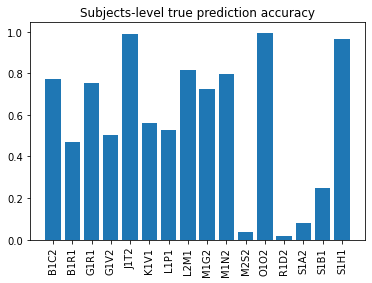

In [7]:
info_correct = {
    key: cross_subjects_informativeness.mean()['correct']['true'][key]
    for key in cross_subjects_informativeness.mean()['correct']['true']
    if key in cross_subjects_informativeness.mean()['wrong']['true']
}

info_wrong = {
    key: cross_subjects_informativeness.mean()['wrong']['true'][key]
    for key in cross_subjects_informativeness.mean()['wrong']['true']
    if key in cross_subjects_informativeness.mean()['correct']['true']
}

info_correct = dict(
    sorted(
        info_correct.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

info_wrong = dict(
    sorted(
        info_wrong.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

tp = np.array(
    list(
        info_correct.values()
    )
)

tn = np.array(
    list(
        info_wrong.values()
    )
)

plt.bar(info_correct.keys(), tp/(tn+tp))
plt.title('Subjects-level true prediction accuracy')
plt.xticks(rotation=90)
plt.show()

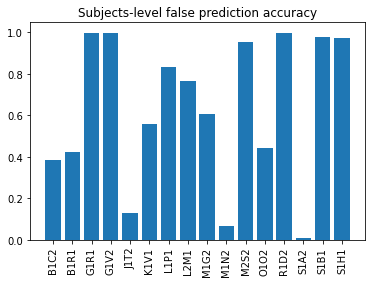

In [8]:
info_correct = {
    key: cross_subjects_informativeness.mean()['correct']['false'][key]
    for key in cross_subjects_informativeness.mean()['correct']['false']
    if key in cross_subjects_informativeness.mean()['wrong']['false']
}

info_wrong = {
    key: cross_subjects_informativeness.mean()['wrong']['false'][key]
    for key in cross_subjects_informativeness.mean()['wrong']['false']
    if key in cross_subjects_informativeness.mean()['correct']['false']
}

info_correct = dict(
    sorted(
        info_correct.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

info_wrong = dict(
    sorted(
        info_wrong.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

tp = np.array(
    list(
        info_correct.values()
    )
)

tn = np.array(
    list(
        info_wrong.values()
    )
)

plt.bar(info_correct.keys(), tp/(tn+tp))
plt.title('Subjects-level false prediction accuracy')
plt.xticks(rotation=90)
plt.show()

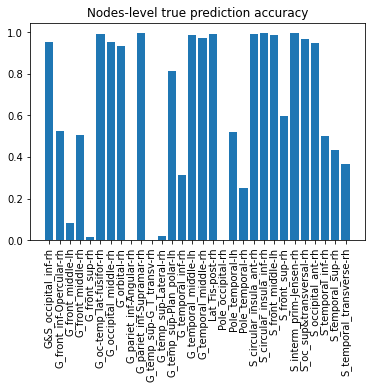

In [9]:
info_correct = {
    key: cross_nodes_informativeness.mean()[0]['correct']['true'][key]
    for key in cross_nodes_informativeness.mean()[0]['correct']['true']
    if key in cross_nodes_informativeness.mean()[0]['wrong']['true']
}

info_wrong = {
    key: cross_nodes_informativeness.mean()[0]['wrong']['true'][key]
    for key in cross_nodes_informativeness.mean()[0]['wrong']['true']
    if key in cross_nodes_informativeness.mean()[0]['correct']['true']
}

info_correct = dict(
    sorted(
        info_correct.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

info_wrong = dict(
    sorted(
        info_wrong.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

tp = np.array(
    list(
        info_correct.values()
    )
)

tn = np.array(
    list(
        info_wrong.values()
    )
)

plt.bar(info_correct.keys(), tp/(tn+tp))
plt.title('Nodes-level true prediction accuracy')
plt.xticks(rotation=90)
plt.show()

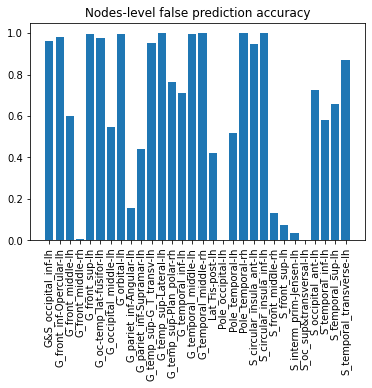

In [10]:
info_correct = {
    key: cross_nodes_informativeness.mean()[0]['correct']['false'][key]
    for key in cross_nodes_informativeness.mean()[0]['correct']['false']
    if key in cross_nodes_informativeness.mean()[0]['wrong']['false']
}

info_wrong = {
    key: cross_nodes_informativeness.mean()[0]['wrong']['false'][key]
    for key in cross_nodes_informativeness.mean()[0]['wrong']['false']
    if key in cross_nodes_informativeness.mean()[0]['correct']['false']
}

info_correct = dict(
    sorted(
        info_correct.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

info_wrong = dict(
    sorted(
        info_wrong.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

tp = np.array(
    list(
        info_correct.values()
    )
)

tn = np.array(
    list(
        info_wrong.values()
    )
)

plt.bar(info_correct.keys(), tp/(tn+tp))
plt.xticks(rotation=90)
plt.title('Nodes-level false prediction accuracy')
plt.show()


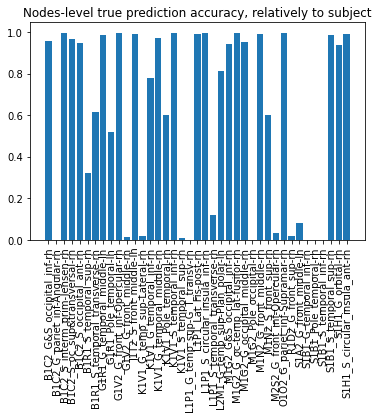

In [11]:
info_correct = {
    key: cross_nodes_informativeness.mean()[1]['correct']['true'][key]
    for key in cross_nodes_informativeness.mean()[1]['correct']['true']
    if key in cross_nodes_informativeness.mean()[1]['wrong']['true']
}

info_wrong = {
    key: cross_nodes_informativeness.mean()[1]['wrong']['true'][key]
    for key in cross_nodes_informativeness.mean()[1]['wrong']['true']
    if key in cross_nodes_informativeness.mean()[1]['correct']['true']
}

info_correct = dict(
    sorted(
        info_correct.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

info_wrong = dict(
    sorted(
        info_wrong.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

tp = np.array(
    list(
        info_correct.values()
    )
)

tn = np.array(
    list(
        info_wrong.values()
    )
)

plt.bar(info_correct.keys(), tp/(tn+tp))
plt.xticks(rotation=90)
plt.title('Nodes-level true prediction accuracy, relatively to subject')
plt.show()

# print(
#     dict_to_str(info_wrong)
# )

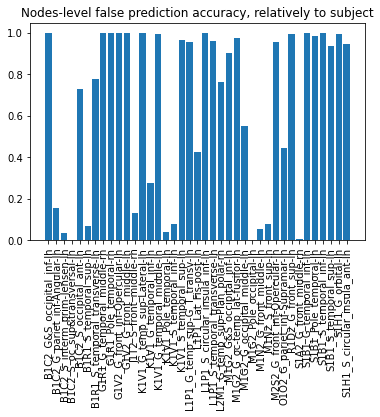

In [12]:
info_correct = {
    key: cross_nodes_informativeness.mean()[1]['correct']['false'][key]
    for key in cross_nodes_informativeness.mean()[1]['correct']['false']
    if key in cross_nodes_informativeness.mean()[1]['wrong']['false']
}

info_wrong = {
    key: cross_nodes_informativeness.mean()[1]['wrong']['false'][key]
        # clf = LogisticRegression(class_weight={True: 1, False: .8})
        # clf = LogisticRegression()
        # clf = RandomFor
    for key in cross_nodes_informativeness.mean()[1]['wrong']['false']
    if key in cross_nodes_informativeness.mean()[1]['correct']['false']
}

info_correct = dict(
    sorted(
        info_correct.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

info_wrong = dict(
    sorted(
        info_wrong.items(),
        key= lambda item: item[0],
        reverse=False
    )
)

tp = np.array(
    list(
        info_correct.values()
    )
)

tn = np.array(
    list(
        info_wrong.values()
    )
)

plt.bar(info_correct.keys(), tp/(tn+tp))
plt.xticks(rotation=90)
plt.title('Nodes-level false prediction accuracy, relatively to subject')
plt.show()

# print(
#     dict_to_str(info_wrong)
# )

In [ ]:
# features = ['0.5-4Hz_wpli', '4-7Hz_wpli', '7-14Hz_wpli', '14-30Hz_wpli', '30-70Hz_wpli']
# features = ['14-30Hz_wpli', '4-7Hz_wpli']
# features = ['4-7Hz_wpli', '4-7Hz_envelope']
# features = ['4-7Hz_wpli', '4-7Hz_envelope']
features = ['wpli', 'envelope']
# features = ['4-7Hz_wpli']
# features = ['envelope']
# features = ['4-7Hz_wpli', '4-7Hz_psd']
acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()
stat = stat1
for i in range(1000):
    # clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=10)
    # clf = AdaBoostClassifier(n_estimators=10, random_state=0)
    # clf = svm.SVC(kernel='linear')
    clf = svm.SVC(class_weight={True: .9, False: 1}, probability=True)
    # clf = KNeighborsClassifier(n_neighbors=3)
    # clf = LogisticRegression()
    # clf = RandomForestClassifier(max_depth=20)
    # clf = GaussianNB()
    # clf = LinearDiscriminantAnalysis()
    # clf = KMeans(n_clusters=2, algorithm='full')
    # clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10, 10), max_iter=1450)

    true_data = stat.datasets['true'][features]
    # false_data = stat1.random_samples()[features]
    # false_data = stat1.datasets['false_res'][features]
    # true_data = stat1.random_samples()[features]
    # false_data = stat.random_samples()[features]
    # false_data = lmd.lead_std(stat.datasets['false_res'][features], take_std_from=stat.datasets['true'][features], axis=1)
    false_data = stat.datasets['false_mirror'][features]
    true_data = true_data.assign(resected=True)
    false_data = false_data.assign(resected=False)
    dataset = pd.concat([true_data, false_data], axis=0)
    dataset = dataset.sample(frac = 1)


    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    # scaler = MaxAbsScaler()
    # scaler = RobustScaler()



    y = dataset['resected'].to_numpy()
    dataset = dataset.drop(['resected'], axis=1)


    # dataset = lmd.lead_std(dataset, take_std_from=stat1.datasets['false_res'][features], axis=1)
    dataset = lmd.suppress(dataset, axis=1, optimal='max')
    # dataset = lmd.promote(dataset, axis=1, optimal='min')
    # dataset = lmd.clusterize(dataset, axis=1, n_clusters=3, optimal='max')
    # dataset = lmd.binarize(dataset, axis=1)


    x = scaler.fit_transform(dataset)
    # x = dataset
    scores = cross_val_score(clf, x, y, cv=10)
    acc.append(scores.mean())

print('Accuracy: ', sum(acc)/len(acc), min(acc), max(acc))

In [ ]:
# from nodestimation.mlearning.features import prepare_connectivity, prepare_data
# con = pkl.load(open(subjects[0].data['con'], 'rb'))

subjects_dir, subjects_ = find_subject_dir()
labels = mne.read_labels_from_annot('B1C2', parc='aparc', subjects_dir=subjects_dir)
label_names = [label.name for label in labels]
lh_labels = [name for name in label_names if name.endswith('lh')]
rh_labels = [name for name in label_names if name.endswith('rh')]

label_ypos_lh = list()

for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos_lh.append(ypos)

try:
    idx = label_names.index('Brain-Stem')

except ValueError:
    pass

else:
    ypos = np.mean(labels[idx].pos[:, 1])
    lh_labels.append('Brain-Stem')
    label_ypos_lh.append(ypos)


lh_labels = [label for (yp, label) in sorted(zip(label_ypos_lh, lh_labels))]

rh_labels = [label[:-2] + 'rh' for label in lh_labels
             if label != 'Brain-Stem' and label[:-2] + 'rh' in rh_labels]


node_colors = [label.color for label in labels]

node_order = lh_labels[::-1] + rh_labels

node_angles = mne.viz.circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) // 2])

In [ ]:
# methods = [
#     'coh',
#     'imcoh',
#     'plv',
#     'ciplv',
#     'ppc',
#     'pli'
# ]
#
# freq_bands = [
#     '0.5-4Hz',
#     '4-7Hz',
#     '7-14Hz',
#     '14-30Hz'
# ]
#
# for method in methods:
#     for freq_band in freq_bands:
#         fig = plt.figure(num=None, figsize=(25, 25), facecolor='black')
#         mne.viz.plot_connectivity_circle(con[freq_band][method]['con'][:, :, 0], label_names, n_lines=300,
#                                          node_angles=node_angles, node_colors=node_colors,
#                                          title='All-to-All Connectivity Epilepsy Condition ({} for {})'
#                                          .format(method, freq_band), padding=8, fontsize_title=35, fontsize_colorbar=25,
#                                          fontsize_names=20, fig=fig
#                                          )

In [ ]:
for subject in [subjects[0]]:
    fig, ax = plt.subplots(figsize=(15,15))
    display = nplt.plot_glass_brain(None, display_mode='lyrz', figure=fig, axes=ax)
    spared = [node.center_coordinates for node in subject.nodes if node.type == 'spared']
    resected = [node.center_coordinates for node in subject.nodes if node.type == 'resected']
    # resection = read['resec-mni'](subject.data['resec-mni'])
    # display.add_markers(resection, marker_color="violet", marker_size=1)
    display.add_markers(np.array(spared), marker_color="yellow", marker_size=100)
    display.add_markers(np.array(resected), marker_color="red", marker_size=250)

In [ ]:
for subject in subjects[0:1]:
    fig, ax = plt.subplots(figsize=(15,15))
    display = nplt.plot_glass_brain(None, display_mode='lyrz', figure=fig, axes=ax)
    spared = [node.center_coordinates for node in subject.nodes if node.type == 'spared']
    resected = [node.center_coordinates for node in subject.nodes if node.type == 'resected']
    # resection = read['resec-mni'](subject.data['resec-mni'])
    # display.add_markers(resection, marker_color="violet", marker_size=1)
    display.add_markers(np.array(spared), marker_color="yellow", marker_size=100)
    display.add_markers(np.array(resected), marker_color="red", marker_size=250)
    plt.show()

    # fig, ax = plt.subplots(figsize=(10,4))
    nodes = np.array([node.center_coordinates for node in subject.nodes])
    print(subject.datasets.keys())
    nplt.plot_markers(subject.datasets['between']['4-8Hz_envelope']*subject.datasets['eigen']['4-8Hz_wpli'],
                      nodes, node_size=30, node_cmap='YlOrBr')
    plt.show()

